In [14]:
from __future__ import division
import numpy as np
import sys
import matplotlib.pylab as plt
#import vampy.utils as utils
import pandas as pd
import open3d as o3d


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import interp1d

https://stackoverflow.com/questions/35612235/how-to-read-numpy-2d-array-from-string

In [31]:
#load in vessel data frame

try:
    vessel_df = pd.read_pickle ('C:\\Users\\cbnor\\Documents\\Full Body Flow Model Project\\rleg.pkl')
except:
    vessel_df = pd.read_pickle ('C:\\Users\\Cassidy.Northway\\GitRemoteRepo\\rleg.pkl')
print(vessel_df)

                 Name                                  Centre Axis Array  \
0    arteries_rleg0_0  [[-107.4632424731635, -5.938743137985156, -133...   
1    arteries_rleg1_0  [[-114.96594771700069, -4.516197961396698, -14...   
2    arteries_rleg1_1  [[-114.88989852866645, -2.403195732162193, -14...   
3    arteries_rleg1_2  [[-114.88989852866645, -2.403195732162193, -14...   
4    arteries_rleg1_3  [[-114.69956053652277, -0.2642367914375668, -1...   
..                ...                                                ...   
65  arteries_rleg28_0  [[-197.49080264872237, -117.06490042604094, -1...   
66  arteries_rleg29_0  [[-214.6341143795293, -69.02840543378994, -103...   
67  arteries_rleg29_1  [[-213.9998099410211, -76.97964714852628, -104...   
68  arteries_rleg29_2  [[-213.87402560440543, -93.67073608487095, -10...   
69  arteries_rleg29_3  [[-213.87402560440543, -93.67073608487095, -10...   

                                         Radius Array End Condition  
0   [1.0006416883

Goal is to modify the artery code to take the information as structured in our DataFrame and be able to use it to create an artery class object to be passsed to the artery network as necessary

In [32]:
#For arm dataframe the intial artery will be the at index 17
index = 2
first_vessel = vessel_df.loc[index]

#How / what happens if we voxelize the central axis data, aka can I create my own version of the X and R vectors not important...
p1_pcd = o3d.geometry.PointCloud()
values = first_vessel.loc['Centre Axis Array']
values = str2array(values)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(values)
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,voxel_size=5)
o3d.visualization.draw_geometries([voxel_grid])

Makes more sense to determine the distance as a total distance (L) then we can determine step size (dx, arbitrary) what we need to do is be able to determine R as a fcn of step size

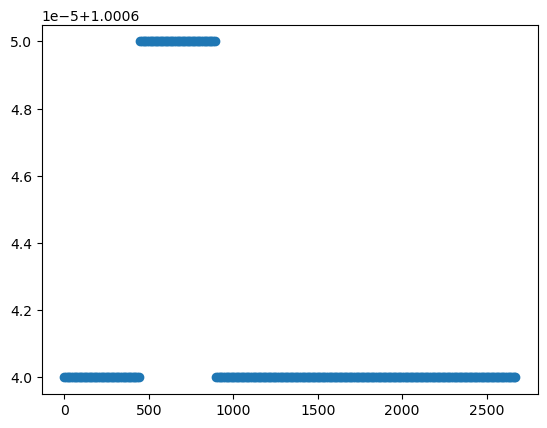

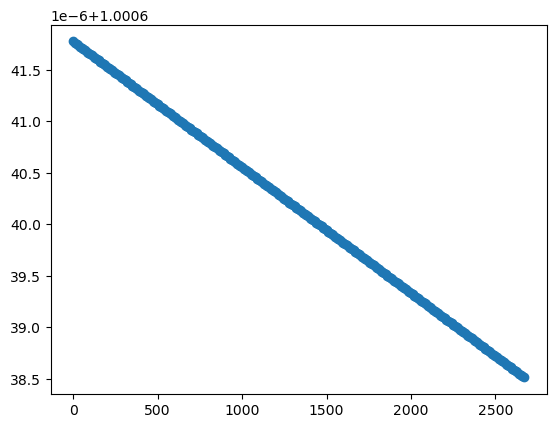

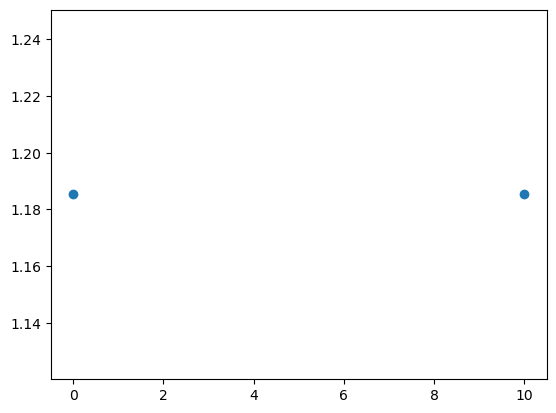

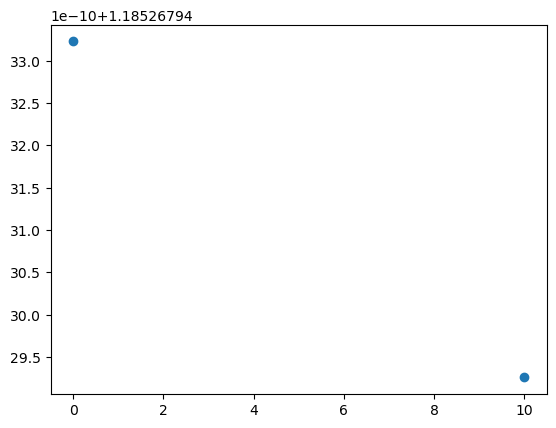

C:\Users\Cassidy.Northway\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Cassidy.Northway\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: index -1 is out of bounds for axis 0 with size 0

In [33]:
# Determine the parameters transformation, add 4th column to central axis data to track distance along track

#Location of values in relation to other via index
for index in range(0,23):
    loc = index 

    #Determine L and prepare to handle calculation of R 
    total_distance = 0
    central_axis = vessel_df.loc[index,'Centre Axis Array']
    central_axis = np.hstack((central_axis, np.zeros((central_axis.shape[0], 1), dtype=central_axis.dtype)))

    for i in range(0,np.shape(central_axis)[0]-1):
        dist = np.linalg.norm(central_axis[i,0:3] - central_axis[i+1,0:3])
        total_distance = total_distance + dist
        central_axis[i+1,3] = total_distance

    L = central_axis[-1,3]
    dx = 10
    nx = int(L/dx)+1

    if nx-1 != L/dx:
        L = dx * (nx-1)
    X = np.linspace(0.0, L, nx)

    #Now we need to interpolate the R values to corresponding X values
    radius = vessel_df.loc[index, 'Radius Array']
    Ru = np.mean(radius[0:5])
    Rd = np.mean(radius[-6:-1])
    R = []
    for x in X:
        idx = (np.abs(central_axis[:,3] - x)).argmin()
        try:
            R.append(radius[idx])
        except:
            R.append(radius[idx-1])
    R= np.round(R,5)   
    plt.scatter(X, R)
    plt.show()
    R_x = Ru * np.power((Rd/Ru), X/L)
    plt.scatter(X, R_x)
    plt.show()


In [21]:
#Now we need to think aobut elasticity parameters and reynold's numbers
if R[0]<3:
    k=[20E6, -22.5, 86.5E4]
else:
    k =[3E6, -9, 33.7E4]
print(k)
    
Re = 2.17 #From example Q

[20000000.0, -22.5, 865000.0]


In [19]:
rc = 1 
qc = 10  
rho = 1.06
p0 = (85 * 1333.22365) * rc**4/(rho*qc**2) # zero transmural pressure

In [20]:

class Artery(object):
    """
    Class representing an artery.
    
    :param pos: Artery ID
    :param Ru: Upstream radius
    :param Rd: Downstream radius
    :param lam: Length-to-radius (upstream) ratio 
    :param k: Iterable containing elasticity parameters k1, k2, k3
    :param Re: Reynold's number
    """
        
        
    def __init__(self, pos, X , R, k, Re, p0,nx):
        """
        Artery constructor.
        """
        self._pos = pos
        self._X = X
        self._R = R
        self._k = k
        self._Re = Re
        self._p0 = p0
        self._nx = nx
        
        
    def initial_conditions(self, u0):
        """
        Initialises solution arrays with initial conditions.
        Checks if artery.mesh(dx) has been called first.
        
        :param u0: Initial conditions for solution
        :param ntr: Number of solution time steps to be stored
        :raises: AttributeError1
        """
        if not hasattr(self, '_nx'):
            raise AttributeError('Artery not meshed. Execute mesh(self, dx) \
before setting initial conditions.')
        self.U0[0,:] = self.A0.copy()
        self.U0[1,:].fill(u0)
        
        
    def mesh(self, ntr):
        """
        Meshes an artery using spatial step size dx.
        
        :param dx: Spatial step size
        """
        Ru =R[0]
        Rd= R[-1]
        self._A0 = np.power(R, 2)*np.pi
        self._f = 4/3 * (self.k[0] * np.exp(self.k[1]*R) + self.k[2])
        self._df = 4/3 * self.k[0] * self.k[1] * np.exp(self.k[1]*R)   
        self._xgrad = (Ru * np.log(Rd/Ru) * np.power((Rd/Ru), X/L))/L #?modified estimate of slope at all points instead of dr/dx
        self.U = np.zeros((2, ntr, self.nx))
        self.P = np.zeros((ntr, self.nx))
        self.U0 = np.zeros((2, self.nx))
        
        
    def boundary_layer_thickness(self, nu, T):
        """
        Calculates the boundary layer thickness of the artery according to
        
        delta = sqrt(nu*T/2*pi).
        
        :param nu: Viscosity of blood
        :param T: Length of one periodic cycle.
        """
        self._delta = np.sqrt(nu*T/(2*np.pi))
        
        
    def p(self, a, **kwargs):
        """
        Calculates pressure according to the state equation.
        
        :param a: Area
        :param \**kwargs: See below
        :returns: Pressure 

        :Keyword Arguments:
            * *j* (``int``) -- Index variable
        """
        if 'j' in kwargs:
            j = kwargs['j']
            p = self.f[j] * (1 - np.sqrt(self.A0[j]/a)) + self.p0
        else:
            p = self.f * (1 - np.sqrt(self.A0/a)) + self.p0
        return p
        

    def wave_speed(self, a):
        """
        Calculates the wave speed (required to check CFL condition).
        
        :param a: Area
        :returns: Wave speed
        """
        return -np.sqrt(0.5 * self.f * np.sqrt(self.A0/a))
        
        
    def F(self, U, **kwargs):
        """
        Calculates the flux vector.
        
        :param U: Previous solution
        :param \**kwargs: See below
        :returns: Flux for current solution
        :raises: IndexError
        
        :Keyword Arguments:
            * *j* (``int``) -- Index variable (start)
            * *k* (``int``) -- Index variable (end)
        """
        a, q = U
        out = np.empty_like(U)
        out[0] = q
        if 'j' in kwargs:
            j = kwargs['j']
            a0 = self.A0[j]
            f = self.f[j]
        elif 'k' in kwargs:
            j = kwargs['j']
            k = kwargs['k']
            a0 = self.A0[j:k]
            f = self.f[j:k]
        else:
            raise IndexError("Required to supply at least one index in function F.")
        out[1] = np.power(q, 2)/a + f * np.sqrt(a0*a)
        return out
        
        
    def S(self, U, **kwargs):
        """
        Calculates the flux vector.
        
        :param U: Previous solution
        :param \**kwargs: See below
        :returns: Flux for current solution
        :raises: IndexError
        
        :Keyword Arguments:
            * *j* (``int``) -- Index variable (start)
            * *k* (``int``) -- Index variable (end)
        """
        a, q = U
        out = np.zeros(U.shape)
        if 'j' in kwargs:
            j = kwargs['j']
            a0 = self.A0[j]
            xgrad = self.xgrad[j]
            f = self.f[j]
            df = self.df[j]
        elif 'k' in kwargs:
            j = kwargs['j']
            k = kwargs['k']
            a0 = self.A0[j:k]
            xgrad = self.xgrad[j:k]
            f = self.f[j:k]
            df = self.df[j:k]
        else:
            raise IndexError("Required to supply at least one index in function S.")
        R = np.sqrt(a0/np.pi)
        out[1] = -(2*np.pi*R/(self.Re*self.delta)) * (q/a) +\
                (2*np.sqrt(a) * (np.sqrt(np.pi)*f +\
                np.sqrt(a0)*df) - a*df) * xgrad
        return out
        
        
    def dBdx(self, l, xi):
        """
        Calculates dB/dx (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to dB/dx
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            f_l = utils.extrapolate(l, [x_0, x_1], [self.f[-2], self.f[-1]])  
            A0_l = utils.extrapolate(l, [x_0, x_1], [self.A0[-2], self.A0[-1]])  
            df_l = utils.extrapolate(l, [x_0, x_1], [self.df[-2], self.df[-1]])
            xgrad_l = utils.extrapolate(l, [x_0, x_1],
                                        [self.xgrad[-2], self.xgrad[-1]])
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            f_l = utils.extrapolate(l, [x_0, x_1], [self.f[1], self.f[0]])  
            A0_l = utils.extrapolate(l, [x_0, x_1], [self.A0[1], self.A0[0]]) 
            df_l = utils.extrapolate(l, [x_0, x_1], [self.df[1], self.df[0]])
            xgrad_l = utils.extrapolate(l, [x_0, x_1],
                                        [self.xgrad[1], self.xgrad[0]])
        elif l == self.L:
            f_l = self.f[-1]
            A0_l = self.A0[-1]
            df_l = self.df[-1]
            xgrad_l = self.xgrad[-1]
        else:
            f_l = self.f[0]
            A0_l = self.A0[0]
            df_l = self.df[0]
            xgrad_l = self.xgrad[0]
        return (2*np.sqrt(xi) * (np.sqrt(np.pi)*f_l + np.sqrt(A0_l)*df_l) -\
                    xi*df_l) * xgrad_l
        
        
    def dBdxi(self, l, xi):
        """
        Calculates dB/dx_i (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to dB/dx_i
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            f_l = utils.extrapolate(l, [x_0, x_1], [self.f[-2], self.f[-1]])  
            A0_l = utils.extrapolate(l, [x_0, x_1], [self.A0[-2], self.A0[-1]])  
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            f_l = utils.extrapolate(l, [x_0, x_1], [self.f[1], self.f[0]])  
            A0_l = utils.extrapolate(l, [x_0, x_1], [self.A0[1], self.A0[0]]) 
        elif l == self.L:
            f_l = self.f[-1]
            A0_l = self.A0[-1]
        else:
            f_l = self.f[0]
            A0_l = self.A0[0]
        return f_l/2 * np.sqrt(A0_l/xi)
        
        
    def dBdxdxi(self, l, xi):
        """
        Calculates d^2B/dxdx_i (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to d^2B/dxdx_i
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            f_l = utils.extrapolate(l, [x_0, x_1], [self.f[-2], self.f[-1]])   
            df_l = utils.extrapolate(l, [x_0, x_1], [self.df[-2], self.df[-1]])   
            A0_l = utils.extrapolate(l, [x_0, x_1], [self.A0[-2], self.A0[-1]])  
            xgrad_l = utils.extrapolate(l, [x_0, x_1],
                                        [self.xgrad[-2], self.xgrad[-1]])
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            f_l = utils.extrapolate(l, [x_0, x_1], [self.f[1], self.f[0]])   
            df_l = utils.extrapolate(l, [x_0, x_1], [self.df[1], self.df[0]])   
            A0_l = utils.extrapolate(l, [x_0, x_1], [self.A0[1], self.A0[0]])  
            xgrad_l = utils.extrapolate(l, [x_0, x_1],
                                        [self.xgrad[1], self.xgrad[0]])
        elif l == self.L:
            f_l = self.f[-1]   
            df_l = self.df[-1]
            A0_l = self.A0[-1]
            xgrad_l = self.xgrad[-1]
        else:
            f_l = self.f[0]   
            df_l = self.df[0]
            A0_l = self.A0[0]
            xgrad_l = self.xgrad[0]
        return (1/(2*np.sqrt(xi)) * (f_l*np.sqrt(np.pi) +\
                                    df_l*np.sqrt(A0_l)) - df_l) * xgrad_l
                                    
                                    
    def dFdxi2(self, l, xi1, xi2):
        """
        Calculates dF/dx_2 (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to dF/dx_2
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            R0_l = utils.extrapolate(l, [x_0, x_1], 
                    [np.sqrt(self.A0[-2]/np.pi), np.sqrt(self.A0[-1]/np.pi)])
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            R0_l = utils.extrapolate(l, [x_0, x_1], 
                    [np.sqrt(self.A0[1]/np.pi), np.sqrt(self.A0[0]/np.pi)])
        elif l == self.L:
            R0_l = np.sqrt(self.A0[-1]/np.pi)
        else:
            R0_l = np.sqrt(self.A0[0]/np.pi)
        return 2*np.pi*R0_l/(self.delta*self.Re) * xi1/(xi2*xi2)
        
        
    def dFdxi1(self, l, xi2):
        """
        Calculates dF/dx_1 (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to dF/dx_1
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            R0_l = utils.extrapolate(l, [x_0, x_1], 
                    [np.sqrt(self.A0[-2]/np.pi), np.sqrt(self.A0[-1]/np.pi)])
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            R0_l = utils.extrapolate(l, [x_0, x_1], 
                    [np.sqrt(self.A0[1]/np.pi), np.sqrt(self.A0[0]/np.pi)])
        elif l == self.L:
            R0_l = np.sqrt(self.A0[-1]/np.pi)
        else:
            R0_l = np.sqrt(self.A0[0]/np.pi)
        return -2*np.pi*R0_l/(self.delta*self.Re) * 1/xi2
        
        
    def dpdx(self, l, xi):
        """
        Calculates dp/dx (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to dp/dx
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            f_l = utils.extrapolate(l, [x_0, x_1], [self.f[-2], self.f[-1]])   
            A0_l = utils.extrapolate(l, [x_0, x_1], [self.A0[-2], self.A0[-1]])  
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            f_l = utils.extrapolate(l, [x_0, x_1], [self.f[1], self.f[0]])   
            A0_l = utils.extrapolate(l, [x_0, x_1], [self.A0[1], self.A0[0]])
        elif l == self.L:
            f_l = self.f[-1]   
            A0_l = self.A0[-1]
        else:
            f_l = self.f[0]   
            A0_l = self.A0[0]
        return f_l/2 * np.sqrt(A0_l/xi**3)
        
        
    def solve(self, lw, U_in, U_out, save, i):
        """
        Solver calling the LaxWendroff solver and storing the new solution in U0.
        Stores new solution in output array U if save is True.
        
        :param lw: LaxWendroff object
        :param U_in: Inlet boundary condition
        :param U_out: Outlet boundary condition
        :param save: True if current time step is to be saved
        :param i: Current time step
        """
        # solve for current timestep
        U1 = lw.solve(self.U0, U_in, U_out, self.F, self.S)
        if save:
            self.P[i,:] = self.p(self.U0[0,:])
            np.copyto(self.U[:,i,:], self.U0)
        np.copyto(self.U0, U1)
        
        
        
    def dump_results(self, suffix, data_dir):
        """
        Outputs solutions U, P to csv files
        
        :param suffix: Simulation identifier
        :param data_dir: Directory data files are stored in
        """
        np.savetxt("%s/%s/u%d_%s.csv" % (data_dir, suffix, self.pos, suffix),
                   self.U[1,:,:], delimiter=',')
        np.savetxt("%s/%s/a%d_%s.csv" % (data_dir, suffix, self.pos, suffix),
                   self.U[0,:,:], delimiter=',')  
        np.savetxt("%s/%s/p%d_%s.csv" % (data_dir, suffix, self.pos, suffix),
                   self.P, delimiter=',') 
                   
                   
    @property
    def L(self):
        """
        Artery length
        """
        return self._L

    @L.setter
    def L(self, value):
        self._L = value
        
    @property
    def nx(self):
        """
        Number of spatial steps
        """
        return self._nx
        
    @property
    def Ru(self):
        """
        Upstream radius
        """
        return self._Ru
        
    @property
    def Rd(self):
        """
        Downstream radius
        """
        return self._Rd
        
    @property
    def k(self):
        """
        Elasticity parameters for relation Eh/r = k1 * exp(k2*r) + k3
        """
        return self._k
        
    @property
    def A0(self):
        """
        Area at rest
        """
        return self._A0
        
    @property
    def dx(self):
        """
        Spatial step size
        """
        return self._dx
    
    @property
    def pos(self):
        """
        Position in ArteryNetwork
        """
        return self._pos
        
    @property
    def f(self):
        """
        f = 4/3 Eh/r
        """
        return self._f
        
    @property
    def xgrad(self):
        """
        dr/dx
        """
        return self._xgrad
        
    @property
    def df(self):
        """
        df/dr
        """        
        return self._df

    @property
    def Re(self):
        """
        Reynold's number
        """
        return self._Re
        
    @property
    def delta(self):
        """
        Boundary layer thickness
        """
        return self._delta

    @property
    def p0(self):
        """
        Reynold's number
        """
        return self._p0

In [22]:
trial_art = Artery(1, X, R, k, Re, p0,nx)
trial_art.mesh( 20)

In [23]:
T = 0.917
tc = 4
dt = 1e-5
nu = 0.046
trial_art.boundary_layer_thickness(nu, T)
trial_art.initial_conditions(0.0)

In [24]:
#lw parameters. how determined? 
R1 = 25300
R2 = 13900
Ct = 1.3384e-6

trial_art.solve(lw, U_in, U_out, save, i-1)

NameError: name 'lw' is not defined

In [2]:

from __future__ import division

import sys
import numpy as np
from scipy.interpolate import interp1d



class LaxWendroff(object):
    """
    Class implementing Richtmyer's 2 step Lax-Wendroff method.
    """
    
    
    def __init__(self, theta, gamma, nx):
        """
        Constructor for LaxWendroff class.
        
        :param theta: factor for flux vector
        :param gamma: factor for source vector
        :param nx: number of spatial points
        """
        self._theta = theta
        self._gamma = gamma
        self._nx = nx
        

    def solve(self, U0, U_in, U_out, F, S):
        """
        Solver implementing Richtmyer's two-step Lax-Wendroff method [1,2].
        
        [1] R. D. Richtmyer. A Survey of Difference Methods for Non-Steady Fluid Dynamics. NCAR Technical Notes, 63(2), 1963.
        [2] R. J. LeVeque. Numerical Methods for Conservation Laws. Birkhauser Verlag, Basel, Switzerland, 2nd edition, 1992.
        
        :param U0: solution from previous time step
        :param U_in: inlet boundary condition
        :param U_out: outlet boundary condition
        :param F: flux function (see [2])
        :param S: source function (see [2])
        """
        # U0: previous timestep, U1 current timestep
        U1 = np.zeros((2,self.nx))
        # apply boundary conditions
        U1[:,0] = U_in
        U1[:,-1] = U_out
        # calculate half steps
        U_np_mp = (U0[:,2:]+U0[:,1:-1])/2 -\
            self.theta*(F(U0[:,2:], j=2, k=self.nx)-F(U0[:,1:-1], j=1, k=-1))/2 +\
            self.gamma*(S(U0[:,2:], j=2, k=self.nx)+S(U0[:,1:-1], j=1, k=-1))/2
        U_np_mm = (U0[:,1:-1]+U0[:,0:-2])/2 -\
            self.theta*(F(U0[:,1:-1], j=1, k=-1)-F(U0[:,0:-2], j=0, k=-2))/2 +\
            self.gamma*(S(U0[:,1:-1], j=1, k=-1)+S(U0[:,0:-2], j=0, k=-2))/2
        # calculate full step
        U1[:,1:-1] = U0[:,1:-1] -\
            self.theta*(F(U_np_mp, j=1, k=-1)-F(U_np_mm, j=1, k=-1)) +\
            self.gamma*(S(U_np_mp, j=1, k=-1)+S(U_np_mm, j=1, k=-1))
        return U1
        
        
    @property   
    def theta(self):
        """
        dt/dx
        """
        return self._theta
        
    @property   
    def gamma(self):
        """
        dt/2
        """
        return self._gamma
        
    @property   
    def nx(self):
        """
        Number of spatial steps
        """        
        return self._nx